### ASSIGNMENT - 1
### Create a Personal Assistant Agent that can:
    - Have basic conversations
    - Remember user's name and preferences across sessions
    - Perform simple calculations
    - Tell current time/date

In [27]:
from typing import Annotated, List, Dict, Any
from typing_extensions import TypedDict
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver

print("All Imports Succesfull")

All Imports Succesfull


In [28]:
class State(TypedDict):
    messages: Annotated[List, add_messages]

In [29]:
def route(state: State) -> str:
    last_message = state['messages'][-1].content.lower()
    if any(word in last_message for word in ['+', '-', '/', '*']):
        return "calculate"
    elif any(word in last_message for word in ['date', 'time']):
        return "date_time"
    else:
        return "__end__"

In [30]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [31]:
def chatbot_node(state: State) -> Dict[str, Any]:
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

In [32]:
def calculator(state: State) -> Dict[str, Any]:
    exp = state['messages'][-1].content.lower()
    try:
        response = eval(exp)
        reply = f"The answer is {str(response)}"
    except Exception as e:
        reply = "Sorry Could not calculate"
    return {"messages": [AIMessage(content=reply)]}

In [33]:
import datetime
def date_time(state: State) -> Dict[str, Any]:
    user_msg = state['messages'][-1].content.lower()
    now = datetime.datetime.now()

    if "time" in user_msg:
        reply = f"The current time is {now.strftime('%H:%M:%S')}"
    elif "date" in user_msg:
        reply = f"Today's date is {now.strftime('%Y-%m-%d')}"
    else:
        reply = "I can tell you the current time or date if you ask."
    
    return {"messages": [AIMessage(content=reply)]}


In [34]:
graph = StateGraph(State)
graph.add_node("chatbot_node", chatbot_node)
graph.add_node("calculator_node", calculator)
graph.add_node("date_time_node", date_time)

graph.add_edge(START, "chatbot_node")
graph.add_conditional_edges(
    "chatbot_node",
    route,
    {
        "calculate": "calculator_node",
        "date_time": "date_time_node",
        "__end__": END
    }
)
graph.add_edge("calculator_node", END)
graph.add_edge("date_time_node", END)
graph.add_edge("chatbot_node", END)

app = graph.compile(checkpointer=MemorySaver())

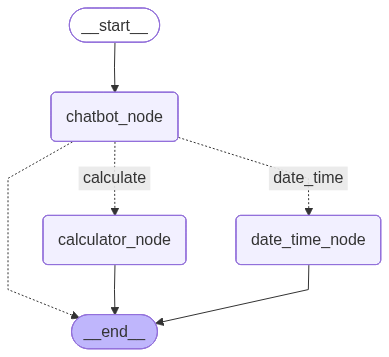

In [35]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [36]:
def test(user_input, thread_id):
    config = {"configurable": {"thread_id": thread_id}}
    state: State = {
        "messages": [HumanMessage(content=user_input)]
    }
    state = app.invoke(state, config=config)
    for m in state['messages']:
        print(m.__class__.__name__, ":", m.content)

In [37]:
test('hi', 'demo-001')

HumanMessage : hi
AIMessage : Hello! How can I assist you today?


In [38]:
test('what was my last question?', 'demo-001')

HumanMessage : hi
AIMessage : Hello! How can I assist you today?
HumanMessage : what was my last question?
AIMessage : Your last question was, "hi." How can I help you further?
